<a href="https://colab.research.google.com/github/nimmitahsin1727/20-news-dataset-lda/blob/main/20_news_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
BASE_PATH = "/content/gdrive/MyDrive/MSC research/document clustering/"

#Importing libraries

In [3]:
import glob
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from string import punctuation
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger') # need for pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#Loading Data

In [4]:
def read_documents_20ng(data_path_train):
  docs = []
  labels = []

  a = glob.glob(os.path.join(data_path_train, '*'))
  for aa in a:
      b = glob.glob(os.path.join(aa, '*'))
      for bb in b:
          with open(bb, encoding='latin1') as f:
              docs.append(f.read())
              labels.append(aa.replace(data_path_train, ''))

  return docs, labels

## Training Data

### Data loading

In [5]:
data_path_train = BASE_PATH + 'data/20news-bydate-train/'

In [6]:
train_docs, train_labels = read_documents_20ng(data_path_train)

In [7]:
print('Training data:', len(train_docs))
print('Number of categories:', len(np.unique(train_labels)))
print('Categories:', np.unique(train_labels))

Training data: 1728
Number of categories: 3
Categories: ['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']


### Finding frequency of each category

In [8]:
len(train_labels)

1728

In [9]:
train_targets, train_frequency = np.unique(train_labels, return_counts=True)
print(train_targets)
print(train_frequency)
print(list(zip(train_targets, train_frequency)))

['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']
[584 598 546]
[('comp.graphics', 584), ('rec.motorcycles', 598), ('talk.politics.guns', 546)]


### Class distribution


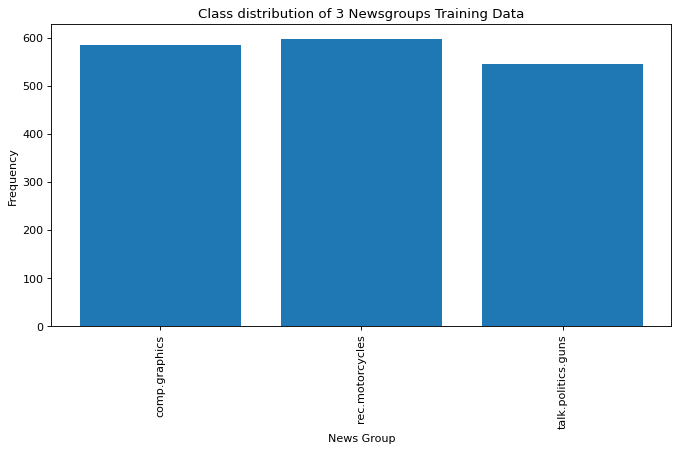

In [10]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(train_targets, train_frequency)
plt.xticks(rotation=90)
plt.title(f'Class distribution of {len(train_targets)} Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

## Testing Data

### Data loading

In [11]:
data_path_test = BASE_PATH + 'data/20news-bydate-test/'

In [12]:
test_docs, test_labels = read_documents_20ng(data_path_test)

In [13]:
print('Testing data:', len(test_docs))
print('Number of categories:', len(np.unique(test_labels)))
print('Categories:', np.unique(test_labels))

Testing data: 1151
Number of categories: 3
Categories: ['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']


### Finding frequency of each category

In [14]:
test_targets, test_frequency = np.unique(test_labels, return_counts=True)
print(test_targets)
print(test_frequency)
print(list(zip(test_targets, test_frequency)))

['comp.graphics' 'rec.motorcycles' 'talk.politics.guns']
[389 398 364]
[('comp.graphics', 389), ('rec.motorcycles', 398), ('talk.politics.guns', 364)]


### Class distribution


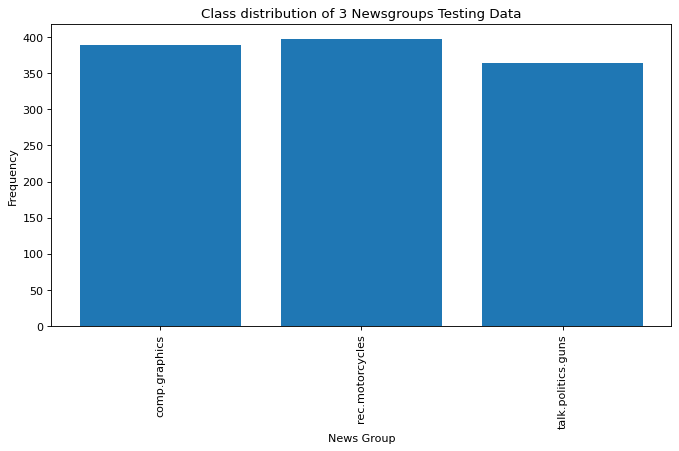

In [15]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(test_targets, test_frequency)
plt.xticks(rotation=90)
plt.title(f'Class distribution of {len(test_targets)} Newsgroups Testing Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

# Pre-process data

## Creating STOP WORDS

Intial stop words from `sklearn.feature_extraction._stop_words`

In [16]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS # Total 318 words

In [17]:
stopWords=list(ENGLISH_STOP_WORDS)

We can also use stopwords from `ntlk`

In [18]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stopWords=stopwords.words('english') # Total 179 words

Adding some more common stop words throughout all docs which doesn't play no part in classification

In [19]:
stopWords+=['subject','from', 'date', 'reply-to', 'newsgroups', 'message-id', 'lines', 'path', 'organization', 
            'would', 'writes', 'references', 'article', 'sender', 'nntp-posting-host', 'people', 
            'university', 'think', 'xref', 'cantaloupe.srv.cs.cmu.edu', 'could', 'distribution', 'first', 
            'anyone', 'really', 'since', 'believe', 'still', 
            "max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'"]

In [20]:
stopWords = set(stopWords)

## Lemmatizer
Lemmatizer minimizes text ambiguity. Example words like bicycle or bicycles are converted to base word bicycle. Basically, it will convert all words having the same meaning but different representation to their base form. It reduces the word density in the given text and helps in preparing the accurate features for training machine. Cleaner the data, the more intelligent and accurate your machine learning model, will be. NLTK Lemmatizer will also saves memory as well as computational cost.

In [21]:
# Initialization
lemmatizer = WordNetLemmatizer()

# Creating a POS tag map
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def convertWordIntoLemmatizeWord(words):
  return [lemmatizer.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(words)]

## Defining a pre-process function

* Remove numbers. ✅
* Convert word into lowercase word. ✅
* Remove all stop words. ✅
* Remove all punctuations. ✅
* Some white spaces may be added to the list of words, due to the translate function & nature of our documents. Remove them as well. ✅
* Remove just-numeric strings. ✅
* Lemmatize. ✅
* Remove words with only 2 characters or less. [Low frequency] ✅
* Remove words with more than 12 characters. [High frequency] ✅


In [22]:
def preprocess(words):
  #First, remove numbers
  words = [re.sub(r"\d+", "", word) for word in words]
  #Normalize the cases of our words
  words = [word.lower() for word in words]
  #Remove all punctuations
  table = str.maketrans('', '', punctuation)
  words = [word.translate(table) for word in words]
  #Some white spaces may be added to the list of words, due to the translate function & nature of our documents. We've to remove them.
  words = [word for word in words if word]
  #Remove just-numeric strings
  words = [word for word in words if not word.isdigit()]
  #Lemmatize
  words = convertWordIntoLemmatizeWord(words)
  #Remove all stop words
  words = [word for word in words if word not in stopWords]
  #Remove words with less than 3 characters and more than 12 characters
  words = [word for word in words if len(word) > 2 and len(word) <= 12]
  return words

## Creating pre-process documents function

In [23]:
def preprocess_documents(docs):
  preprocessed_docs = []
  for doc in docs:
    words = word_tokenize(doc)
    words = preprocess(words)
    preprocessed_docs.append(" ".join(words))
  return preprocessed_docs

## Preprocess training data

Raw data:

In [24]:
train_docs[0]

"From: joth@ersys.edmonton.ab.ca (Joe Tham)\nSubject: Where can I find SIPP?\nOrganization: Edmonton Remote Systems #2, Edmonton, AB, Canada\nLines: 11\n\n        I recently got a file describing a library of rendering routines \ncalled SIPP (SImple Polygon Processor).  Could anyone tell me where I can \nFTP the source code and which is the newest version around?\n        Also, I've never used Renderman so I was wondering if Renderman \nis like SIPP?  ie. a library of rendering routines which one uses to make \na program that creates the image...\n\n                                        Thanks,  Joe Tham\n\n--\nJoe Tham              joth@ersys.edmonton.ab.ca \n"

Pre-processing documents:

In [25]:
preprocessed_train_docs = preprocess_documents(train_docs)

Pre-processed data:

In [26]:
preprocessed_train_docs[0]

'joth joe tham sipp edmonton remote edmonton canada line recently file library render routine sipp simple polygon processor tell ftp source code new version use renderman wonder renderman like sipp library render routine use make program create image thanks joe tham joe tham joth'

Preparing DataFrame:

In [27]:
traing_df = pd.DataFrame({'data': preprocessed_train_docs, 'target': train_labels})
traing_df.head()

,data,target
0,joth joe tham sipp edmonton remote edmonton ca...,comp.graphics
1,ednobles edward noble window imagine oak ridge...,comp.graphics
2,peter van der veen font pov line wageningen ag...,comp.graphics
3,mtoivakk abofi martti toivakka pap compile ver...,comp.graphics
4,rubery dan rubery graphic format tasc line wri...,comp.graphics


## Preprocess testing data

Raw data:

In [28]:
test_docs[0]

'From: lioness@maple.circa.ufl.edu\nSubject: Kubota Kenai/Denali specs\nOrganization: Center for Instructional and Research Computing Activities\nLines: 118\nReply-To: LIONESS@ufcc.ufl.edu\nNNTP-Posting-Host: maple.circa.ufl.edu\n\n\nOkay, I got enough replies about the Kubota Kenai/Denali systems that I\nwill post a summary of their capabilities.  I haven\'t actually used one\nor seen one, so take the specs with a grain of salt.  I\'d like to see\nan independent review of one against, say, an SGI Indigo Extreme or\nsomething.\n\nBasically, the Kenai workstations are DEC Alpha AXP based workstations that\nrun OSF/1 ( DEC\'s ) and will likely run Windows NT in the future.  They are\nbinary compatible with Digital\'s OSF/1 Alpha AXP implementation.  Denali\nis their graphics subsystem, which is upgradable in the field by\nsimply adding "transformation engines".\n\nThe two main Kenai machines are the 3400 Imaging and 3D Graphics Workstation\nand the 3500 Imaging and 3D Graphics Workstatio

Pre-processing documents:

In [29]:
preprocessed_test_docs = preprocess_documents(test_docs)

Pre-processed data:

In [30]:
preprocessed_test_docs[0]

'lioness kubota kenaidenali specs center research computing activity line replyto lioness ufccufledu okay reply kubota kenaidenali post summary capability actually use spec grain salt like independent review say sgi indigo extreme basically kenai workstation dec alpha axp base workstation run osf dec likely run window future binary compatible digital osf alpha axp denali graphic subsystem upgradable field simply add engines main kenai machine imaging graphic workstation imaging graphic workstation cpu dec alpha axp mhz dec alpha axp mhz onchip cache onboard cache word size bit bit memory initial memory future specmark specint specfp graphic transform module frame buffer module frame buff xxbit xxbit double buffer double buffer zbuffer bit bit alphastencil bit bit stereo support yes yes machine double buffer stereo output window auxiliary video output rsa ntsc pal storage max capacity turbochannel mbsec scsi ethernet fddi application programming interface library xlib motif mit pexlib d

Preparing DataFrame:

In [31]:
testing_df = pd.DataFrame({'data': preprocessed_test_docs, 'target': test_labels})
testing_df.head()

,data,target
0,lioness kubota kenaidenali specs center resear...,comp.graphics
1,cummins charles illustrator autotrace poorly a...,comp.graphics
2,dtm efdlthse tomas moeller want scott leatham ...,comp.graphics
3,malek pititechacjp zidouri abdelmalek tiff sig...,comp.graphics
4,kwansik kim kkim csindianaedu faq indiana comp...,comp.graphics


# TF-IDF Vectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

We next convert our corpus into tf-idf vectors.

In [33]:
tfidfV = TfidfVectorizer() 
# tfidfV = TfidfVectorizer(min_df=2) # We remove terms with very low document frequency (many of them are numbers or misspells).

`fit_transform` learns the vocab and one-hot encodes 

In [34]:
X_train_tfidfV = tfidfV.fit_transform(traing_df.data)

In [35]:
print(X_train_tfidfV.shape)

(1728, 22093)


`transform` uses the same vocab and one-hot encodes

In [36]:
X_test_tfidfV = tfidfV.transform(testing_df.data)

In [37]:
print(X_test_tfidfV.shape)

(1151, 22093)


In [38]:
X_train_tfidfV_df = pd.DataFrame(X_train_tfidfV.todense())
X_train_tfidfV_df.columns = sorted(tfidfV.vocabulary_)
X_train_tfidfV_df.head()

,aaa,aaaa,aaah,aad,aaefu,aaffff,aafffff,aalborg,aangeboden,aaplayexe,...,zyhszgv,zyk,zyotso,zyxel,zzc,zzgq,zzr,zzvbs,zzz,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
